# Metalearning an activation function
Sam Greydanus

In this notebook, we will show how to metalearn the activation function of an MLP. Then we will try scaling this activation function to larger models and datasets.

This case study is meant to demonstrate the convenience and computational savings of working with the MNIST-1D dataset. You can find more details at https://github.com/greydanus/mnist1d.

In [3]:
!python -m pip install git+https://github.com/greydanus/mnist1d.git@master
    
# Download repo directly (gives access to notebooks/models.py and notebooks/train.py)
!git clone https://github.com/greydanus/mnist1d

In [10]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.pylab as pl
import time, copy
import torch
import torch.nn.functional as F

import mnist1d

# Try attaching to GPU -- Use "Change Runtime Type to change to GPUT"
DEVICE = str(torch.device('cuda' if torch.cuda.is_available() else 'cpu'))
print('Using:', DEVICE)

plt.style.use('https://github.com/greydanus/mnist1d/raw/master/notebooks/mpl_style.txt')

Using: cpu


## Only run this if you're in Google Colab

In [11]:
if False:
    from google.colab import drive
    drive.mount('/content/gdrive')
    project_dir = "/content/gdrive/My Drive/Research/metalearn_afunc/"
else:
    project_dir = './'

## Visualizing the MNIST-1D dataset
The dataset is procedurally generated from a set of 1D template sequences that look like this:
![MNIST-1D Templates](https://raw.githubusercontent.com/greydanus/greydanus.github.io/master/files/mnist1d_black.png)

These templates were chosen as 1D timeseries analogues to the [MNIST dataset](http://yann.lecun.com/exdb/mnist/):
![MNIST-2D Templates](https://raw.githubusercontent.com/greydanus/greydanus.github.io/master/files/mnist2d_black.png)

It's also possible to plot the 1D templates as lines:

![MNIST-1D Templates (lines)](https://raw.githubusercontent.com/greydanus/greydanus.github.io/master/files/mnist1d_templates.png)

In order to generate a challenging synthetic dataset, we applied a series of transformations to these templates, including linear transformations (up/down), adding correlated noise, and subsampling. Here are some class-wise examples:

![MNIST-1D Templates (lines)](https://raw.githubusercontent.com/greydanus/greydanus.github.io/master/files/mnist1d_transform.png)

The nice thing about this toy dataset is that it does a good job of separating different types of deep learning models, many of which get the same 98-99% test accuracy on MNIST.

![MNIST-1D Benchmarks](https://raw.githubusercontent.com/greydanus/greydanus.github.io/master/files/mnist1d_benchmarks.png)

## Loading the MNIST-1D dataset

In [12]:
args = mnist1d.get_dataset_args()
args.num_samples = 10000
data = mnist1d.get_dataset(args=args, download=False, regenerate=True)  # need to regenerate, since baseline dataset only has 4000/1000 samples

print("Examples in training set: {}".format(len(data['y'])))
print("Examples in test set: {}".format(len(data['y_test'])))
print("Length of each input: {}".format(data['x'].shape[-1]))
print("Number of classes: {}".format(len(data['templates']['y'])))

Did or could not load data from ./mnist1d_data.pkl. Rebuilding dataset...
Examples in training set: 8000
Examples in test set: 2000
Length of each input: 40
Number of classes: 10


## First we need a functional representation of an MLP

This is an important first step when doing gradient-based metalearning. The entire inner training loop needs to be end-to-end differentiable and ordinary PyTorch modules and optimizers were not designed with this in mind. People have come up with various ways to get around the issue. My personal favorite is to make PyTorch look more functional and avoid working with objects at all.


In [13]:
# returns a tuple (state, function) for a vanilla MLP model
def get_functional_mlp(args):
  D, H, O = args.input_size, args.hidden_size, args.output_size
  linear1, linear2 = torch.nn.Linear(D,H), torch.nn.Linear(H,O) # use PyTorch to get initializations
  params = [linear1.weight, linear1.bias, linear2.weight, linear2.bias]
  params = [torch.Tensor(p.reshape(-1)) for p in params]
  param_vec = torch.cat(params).to(args.device)  # flattened vector of parameters, maybe on GPU

  def forward_fn(x, param_vec, afunc): # afunc is a differentiable, elementwise nonlinearity
    pointer = 0
    W1 = param_vec[pointer:pointer+D*H].reshape(H,D)
    pointer += D*H
    b1 = param_vec[pointer:pointer+H].reshape(1,-1)
    pointer += H
    W2 = param_vec[pointer:pointer+H*O].reshape(O,H)
    pointer += O*H
    b2 = param_vec[pointer:pointer+O].reshape(1,-1)

    h = afunc((W1 @ x.t()).t() + b1) #+ noise_post
    h = h + .1*(2*torch.rand(*b1.shape).to(b1.device)-1)  # smooth out gradients w/noise THIS IS IMPORTANT
    logits = (W2 @ h.t()).t() + b2
    return logits
  return param_vec, forward_fn # separates the state from the function

## Inner optimization loop
In the inner loop, we'll train an MLP to classify MNIST-1D images.

In [14]:
# accuracy of the model
def accuracy(model, inputs, targets):
  preds = model(inputs).argmax(-1).cpu().numpy()
  targets = targets.cpu().numpy().astype(np.float32)
  return 100*sum(preds==targets)/len(targets)

def inner_optimization(model, args, data, afunc):
  torch.manual_seed(args.seed)
  (param_vec, fwd_fn) = model
  x_train, x_test = torch.Tensor(data['x']), torch.Tensor(data['x_test'])
  y_train, y_test = torch.LongTensor(data['y']), torch.LongTensor(data['y_test'])
  x_train, x_test, y_train, y_test = [v.to(args.device) for v in [x_train, x_test, y_train, y_test]]

  criterion = torch.nn.CrossEntropyLoss()
  results = {'train_losses': [], 'test_acc': []}
  avg_sq_grad = torch.ones_like(param_vec) # for RMSprop

  for step in range(args.total_steps):
    bix = (args.batch_ix + (step*args.batch_size))%len(x_train) # batch index
    x, y = x_train[bix:bix+args.batch_size], y_train[bix:bix+args.batch_size] # data
    loss = criterion(fwd_fn(x, param_vec, afunc), y) # forward pass

    grads = torch.autograd.grad(loss, param_vec, retain_graph=True, create_graph=True)[0] # get gradients
    avg_sq_grad = avg_sq_grad * args.mu + grads**2 * (1 - args.mu) # RMSProp update line 1
    param_vec = param_vec - args.learning_rate * grads/(torch.sqrt(avg_sq_grad) + 1e-8) # RMSProp update line 2

    results['train_losses'].append(loss)
    if step % args.test_every:
      k = 500  # use first 500 test examples (speeds up inner loop by a factor of 5x)
      test_acc = accuracy(lambda x: fwd_fn(x, param_vec, afunc), x_test[:k], y_test[:k])
      results['test_acc'].append(test_acc)

  results['train_losses'] = torch.stack(results['train_losses'])
  results['test_acc'] = np.asarray(results['test_acc'])
  return results

## Outer optimization loop
The outer (meta) optimization objective is to optimize the activation function of the inner model. We do this by taking the gradient of the average loss over training with respect to a second (meta) MLP which parameterizes the activation function. This approach is called **gradient-based metalearning** since we are computing an exact gradient by backpropagating through the entire unrolled optimization loop. A good paper on this approach is [Maclaurin et al., 2015](https://arxiv.org/abs/1502.03492): _"Gradient-based Hyperparameter Optimization through Reversible Learning."_

In [15]:
# parameterize the activation function. It starts out being perfectly linear
base_activation = torch.nn.ELU()

def mlp_afunc(model, x):
  (param_vec, fwd_fn) = model
  x_hat = 0.2 * fwd_fn(x.reshape(-1, 1), param_vec, torch.tanh)
  x_hat = x_hat.reshape(*x.shape)
  return base_activation(x) + x_hat  # our learned function looks leaky relu-like @ init

def outer_optimization(inner_args, outer_args):
  torch.manual_seed(outer_args.seed)
  torch.cuda.manual_seed_all(outer_args.seed)
  (outer_param_vec, outer_fwd_fn) = outer_model = get_functional_mlp(outer_args)

  t0 = time.time()
  results = {'inner_test_accs':[], 'train_losses':[], 'inner_afunc':[], 'grad_norm':[]}
  momentum = torch.zeros_like(outer_param_vec) # outer loop uses SGD + momentum
  for step in range(outer_args.total_steps):

    # run inner optimization problem
    inner_afunc = lambda x: mlp_afunc(outer_model, x) # parameterize afunc
    inner_model = get_functional_mlp(inner_args) # randomly initialize inner mlp
    inner_results = inner_optimization(inner_model, inner_args, data, inner_afunc)

    # run outer optimization problem
    (outer_param_vec, outer_fwd_fn) = outer_model # unwrap outer model
    outer_loss = inner_results['train_losses'][-200:].mean() # meta loss = mean inner loss
    outer_grads = torch.autograd.grad(outer_loss, outer_param_vec)[0] # meta-gradients
    outer_grads = outer_grads.clamp(-1e-1, 1e-1)  # for stability

    momentum = outer_args.mu * momentum + outer_grads # SGD w/momentum line 1
    outer_param_vec = outer_param_vec - outer_args.learning_rate * momentum # line 2
    outer_model = (outer_param_vec, outer_fwd_fn) # wrap up outer model

    # boring bookkeeping
    results['train_losses'].append(outer_loss.item())
    if step % outer_args.print_every == 0: # print out training progress
      t1 = time.time()
      grad_norm = outer_grads @ outer_grads # to debug when things inevitably blow up
      results['grad_norm'].append(grad_norm.item())
      print('step: {}, dt: {:.1f}s, meta_grad_norm: {:.1e}, mean_inner_loss: {:.3e}, final_inner_loss: {:.3e}, test_acc: {:.1f}'
          .format(step, t1-t0, grad_norm.item(),
                  results['train_losses'][-1],
                  inner_results['train_losses'][-1],
                  inner_results['test_acc'][-1]))
      t0 = t1

    # sample the activation function over x=[-5,5]
    x_fn = torch.linspace(-5,5,steps=100).to(outer_args.device)
    x_fn, y_fn = x_fn.cpu().numpy(), inner_afunc(x_fn).detach().cpu().numpy()
    results['inner_afunc'].append([x_fn, y_fn])
    results['inner_test_accs'].append(inner_results['test_acc'])

  return results

## Hyperparameter settings
Since we have two optimization processes, we'll need _two_ sets of hyperparameters. One of the hardest parts of metalearning is keeping the code organized.

In [ ]:
class ObjectView(object):
    def __init__(self, d): self.__dict__ = d

def get_inner_args(as_dict=False):
  arg_dict = {'input_size': 40,
              'hidden_size': 128,
              'output_size': 10,
              'batch_size': 100,
              'total_steps': 301,
              'test_every': 400,
              'learning_rate': 1e-2,
              'seed': 0,
              'device': DEVICE,
              'mu': 0.4,  # RMSprop momentum term
              'batch_ix': 0}
  return arg_dict if as_dict else ObjectView(arg_dict)

def get_outer_args(as_dict=False):
  arg_dict = {'input_size': 1,
              'hidden_size': 100,
              'output_size': 1,
              'batch_size': 1,
              'learning_rate': 3e-1,
              'mu': 0.0,  # SGD momentum term
              'total_steps': 301,
              'print_every': 1,
              'device': DEVICE,
              'seed': 0}
  return arg_dict if as_dict else ObjectView(arg_dict)

inner_args, outer_args = get_inner_args(), get_outer_args()
mnist1d.set_seed(outer_args.seed)
results = outer_optimization(inner_args, outer_args)

step: 0, dt: 4.8s, meta_grad_norm: 5.2e-02, mean_inner_loss: 1.352e+00, final_inner_loss: 1.353e+00, test_acc: 48.6
step: 1, dt: 4.9s, meta_grad_norm: 8.4e-02, mean_inner_loss: 1.314e+00, final_inner_loss: 1.284e+00, test_acc: 50.6
step: 2, dt: 4.9s, meta_grad_norm: 9.4e-02, mean_inner_loss: 1.284e+00, final_inner_loss: 1.248e+00, test_acc: 52.6
step: 3, dt: 5.0s, meta_grad_norm: 1.2e-01, mean_inner_loss: 1.252e+00, final_inner_loss: 1.208e+00, test_acc: 55.4
step: 4, dt: 5.0s, meta_grad_norm: 1.5e-01, mean_inner_loss: 1.212e+00, final_inner_loss: 1.156e+00, test_acc: 58.4
step: 5, dt: 5.0s, meta_grad_norm: 1.2e-01, mean_inner_loss: 1.170e+00, final_inner_loss: 1.089e+00, test_acc: 59.2
step: 6, dt: 5.0s, meta_grad_norm: 1.3e-01, mean_inner_loss: 1.132e+00, final_inner_loss: 1.050e+00, test_acc: 59.4
step: 7, dt: 5.1s, meta_grad_norm: 1.3e-01, mean_inner_loss: 1.093e+00, final_inner_loss: 1.023e+00, test_acc: 61.0
step: 8, dt: 5.2s, meta_grad_norm: 6.6e-02, mean_inner_loss: 1.058e+00, 

## Evaluate some baseline activation functions
We'll just pass them through the inner training loop once

In [ ]:
afuncs = [torch.relu, lambda x: x*torch.sigmoid(x), torch.nn.ELU(), \
          torch.nn.Softplus(), torch.tanh, torch.sigmoid]
afunc_names = ['relu','swish', 'elu', 'softplus', 'tanh', 'sigmoid']
afunc_colors = ['yellow', 'orange', 'red', 'purple', 'blue', 'green']

baseline_results = []
results['baselines'] = [] # save these baselines to overall results
for i, f in enumerate(afuncs):
  torch.manual_seed(inner_args.seed)
  inner_model = get_functional_mlp(inner_args)
  r = inner_optimization(inner_model, inner_args, data, afunc=f)
  baseline_results.append(r)
  results['baselines'] += [(afunc_names[i],  r['test_acc'][-1], afunc_colors[i])]

In [ ]:
print(np.mean(results['train_losses']))
print(afunc_names)
[r['train_losses'].detach().cpu().numpy().mean() for r in baseline_results]

## Loading and saving results

In [ ]:
# saving
run_tag = 'steps{:.0f}_seed{:.0f}_lr{:.0e}_elu_init' \
        .format(outer_args.total_steps, outer_args.seed,
                outer_args.learning_rate)
mnist1d.to_pickle(results, path=project_dir + run_tag)
print('saved: {}'.format(run_tag))

In [ ]:
# loading
run_tag = run_tag# 'steps100_seed0_lr1e+00_linear_init'
results = mnist1d.from_pickle(path=project_dir + run_tag)
print('loaded: {}'.format(run_tag))

## Examine our results

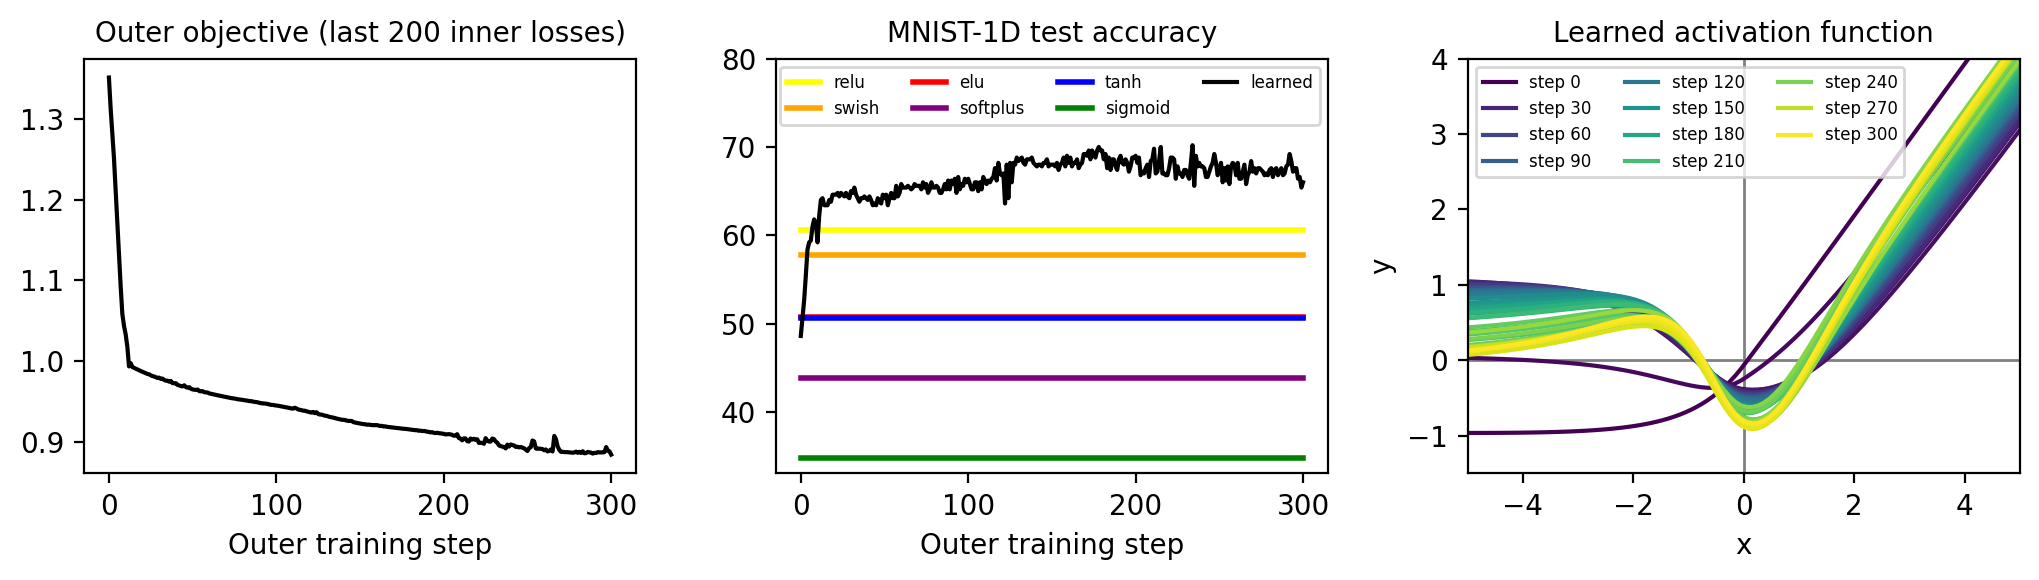

In [ ]:
fig = plt.figure(figsize=(10.3, 3), dpi=200)
t = range(0,outer_args.total_steps, outer_args.print_every)

plt.subplot(1,3,1)
plt.plot(results['train_losses'], 'k-', label='Final training loss')
plt.title('Outer objective (last 200 inner losses)', fontsize=10)
plt.xlabel("Outer training step")

plt.subplot(1,3,2)
meta_test_acc = [r[-1] for r in results['inner_test_accs']]
for (name, acc, color) in results['baselines']:
  plt.plot(t, [acc]*len(t), '-', color=color, label=name, linewidth=2)
plt.plot(t, meta_test_acc, 'k-', label='learned')
plt.title('MNIST-1D test accuracy', fontsize=10) ; plt.xlabel("Outer training step")
plt.ylim(None, 80)
plt.legend(fontsize=6, ncol=4)

plt.subplot(1,3,3)
plt.plot([0, 0], [-6,6], '-', color='gray', linewidth=1)
plt.plot([-6, 6], [0,0], '-', color='gray', linewidth=1)
N = len(results['inner_afunc'])
colors = pl.cm.viridis(np.linspace(0,1,N))
for i, (x, y) in enumerate( results['inner_afunc']):
  if i%(N//50)==0 or i==len(results['inner_afunc']):
    l, m = 0,100 #30,70
    if i%(N//10)==0 or i==len(results['inner_afunc']):
      label = 'step {}'.format(i*outer_args.print_every)
    else:
      label=None
    plt.plot(x[l:m], y[l:m], 'k-', color=colors[i], label=label)
plt.legend(fontsize=6,ncol=3) ; plt.title("Learned activation function", fontsize=10)
plt.xlim(-5,5) ; plt.ylim(-1.5,4)
plt.xlabel("x") ; plt.ylabel("y")
plt.tight_layout() ; plt.show()
fig.savefig(project_dir + 'metalearn_afunc.png')
fig.savefig(project_dir + 'metalearn_afunc.pdf')
# fig.savefig(project_dir + '{}.png'.format(run_tag))

## Approximate the learned activation
Now let's approximate our learned activation as a piecewise polynomial. We could use `np.polyfit` to find a high-order polynomial approximation, but it turns out that linear (polynomial order 1) approximations work just fine.

In [ ]:
def polyfunc(coeffs):
  # designed to work on scalars, np arrays, and Tensors (you can backprop through it too)
  def f(x):
    r = 0.*x
    for i, c in enumerate(coeffs[::-1]):
      r += c * x**i
    return r
  return f

def get_approx_afun():
  # designed to work on scalars, np arrays, and Tensors
  def f(x):
    seg0, seg1, seg2, seg3, seg4, seg5 = [.15, .9], [-.25, 0.1], [-1.2, -.85], [-.5, -.75], [0.2, -.85], [1.2, -1.4]
    y = (x < -2) * polyfunc(seg0)(x) + \
        (x > -2) * (x < -1) * polyfunc(seg1)(x) + \
        (x > -1) * (x < -0.25) * polyfunc(seg2)(x) + \
        (x > -0.25) * (x < 0.1) * polyfunc(seg3)(x) + \
        (x > 0.1) * (x < .6) * polyfunc(seg4)(x) + \
        (x > .6) * polyfunc(seg5)(x)
    return y
  return f

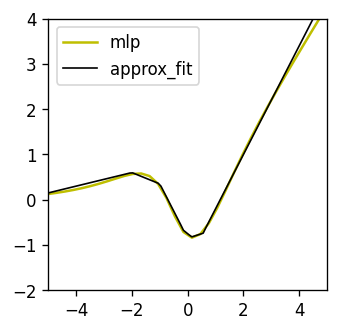

In [ ]:
# plot a comparison
fig = pl.figure(figsize=[3,3],dpi=120)

approx_afunc = get_approx_afun()
x, y = results['inner_afunc'][-1]
plt.plot(x[::3], y[::3], 'y-', label='mlp')
x_ = np.linspace(-5,5,100)
plt.plot(x_, approx_afunc(x_), 'k-', label='approx_fit', linewidth=1)
plt.legend() ; plt.xlim(-5,5) ; plt.ylim(-2,4) ; plt.show()

## Evaluate the fitted piecewise activation function

In [ ]:
torch.manual_seed(inner_args.seed)
inner_model = get_functional_mlp(inner_args)
poly_results = inner_optimization(inner_model, inner_args, data, afunc=approx_afunc)
results['baselines'] += [('approx_fit', poly_results['test_acc'][-1], 'grey')]
poly_results['test_acc'][-1]

64.8

## Add it to our results

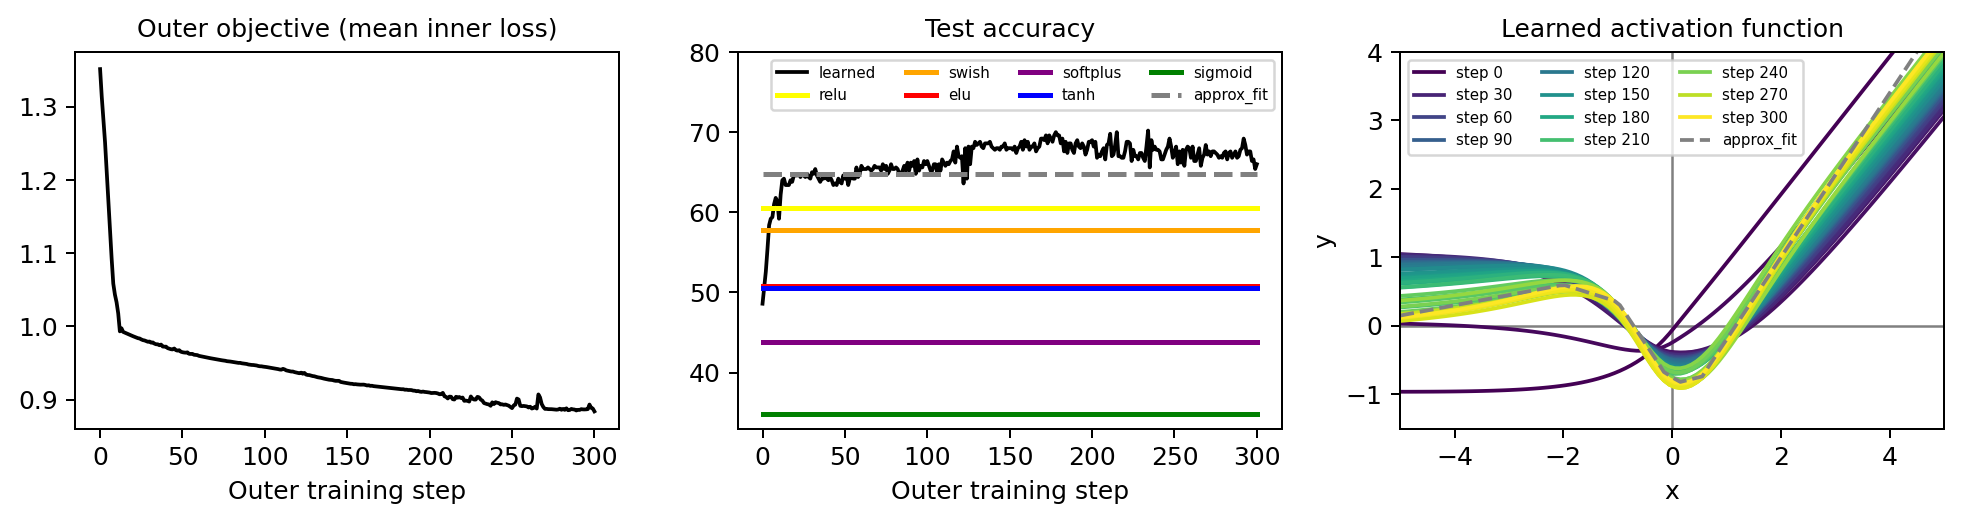

In [ ]:
fig = plt.figure(figsize=(11, 3), dpi=180)
t = range(0,outer_args.total_steps, outer_args.print_every)

plt.subplot(1,3,1)
plt.plot(results['train_losses'], 'k-', label='Final training loss')
plt.title('Outer objective (mean inner loss)', fontsize=10)
plt.xlabel("Outer training step")

plt.subplot(1,3,2)
meta_test_acc = [r[-1] for r in results['inner_test_accs']]
plt.plot(t, meta_test_acc, 'k-', label='learned')
for (name, acc, color) in results['baselines']:
  line = '--' if name == 'approx_fit' else '-'
  plt.plot(t, [acc]*len(t), line, color=color, label=name, linewidth=2)
plt.title('Test accuracy', fontsize=10) ; plt.xlabel("Outer training step")
plt.ylim(None, 80)
plt.legend(fontsize=6, ncol=4)

plt.subplot(1,3,3)
plt.plot([0, 0], [-6,6], '-', color='gray', linewidth=1)
plt.plot([-6, 6], [0,0], '-', color='gray', linewidth=1)
N = len(results['inner_afunc'])
colors = pl.cm.viridis(np.linspace(0,1,N))
for i, (x, y) in enumerate( results['inner_afunc']):
  if i%(N//50)==0 or i==len(results['inner_afunc']):
    l, m = 0,100 #30,70
    if i%(N//10)==0 or i==len(results['inner_afunc']):
      label = 'step {}'.format(i*outer_args.print_every)
    else:
      label=None
    plt.plot(x[l:m], y[l:m], 'k-', color=colors[i], label=label)
plt.plot(x[l:m], approx_afunc(x[l:m]), '--', color='grey', label='approx_fit'.format(i))
plt.legend(fontsize=6,ncol=3) ; plt.title("Learned activation function", fontsize=10)
plt.xlim(-5,5) ; plt.ylim(-1.5,4)
plt.xlabel("x") ; plt.ylabel("y")
plt.tight_layout() ; plt.show()
# fig.savefig(project_dir + '{}_approx.png'.format(run_tag))
fig.savefig(project_dir + 'metalearn_afunc_approx.png')
fig.savefig(project_dir + 'metalearn_afunc_approx.pdf')

## Does it transfer?

It transfers reasonably well, but it's not SOTA.

When we transfer it to convolutional models trained on MNIST and CIFAR10, it does well in terms of mean training loss during the first epoch (which is roughly speaking the objective it was trained on in this notebook). However, it's a bit worse than ReLU, Swish, and Elu for training these larger models to convergence. If we were to perform metalearning on a longer inner training loop or run the same code on larger models & datasets, we could, in theory, do at least as well as the best hand-designed activation function — and probably a decent bit better. We leave this to future work.

* Transferring to a CNN trained on MNIST (email me if you'd like access)
* Transferring to a CNN trained on CIFAR10  (email me if you'd like access)